In [4]:
import pandas as pd
import numpy as np
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from scipy.optimize import minimize
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

CAUSAL INFERENCE - PRODUCTION RUN
Loading and aggregating data to state level...
Loaded 413 state-year observations

[1/3] DIFFERENCE-IN-DIFFERENCES

Pre-treatment trends:
  Control states slope: -0.028035
  Treated states slope: -0.013362

DiD Regression Results:
--------------------------------------------------------------------------------
Treatment Effect: 0.080873 tons/MWh
Standard Error: 0.015083
T-statistic: 5.362
P-value: 0.0000
95% CI: [0.051311, 0.110436]

✓ Policy significantly increased carbon intensity by 17.6%

Event Study (dynamic effects):
  ✓ Pre-trends look parallel (coefficients near zero)

[2/3] SYNTHETIC CONTROL (Treated: CA)

Synthetic CA composed of:
  VT: 15.8%
  ID: 11.6%
  WA: 11.2%
  OR: 7.6%
  NH: 7.0%
  DC: 6.6%
  ME: 6.5%
  IA: 2.8%
  OK: 2.5%
  NY: 2.1%

Pre-treatment fit RMSE: 0.000350
Average treatment effect: 0.009575 tons/MWh

[3/3] PROPENSITY SCORE MATCHING
  Note: Using simplified state-level demo (real PSM requires plant-level data)

Propensity Sc

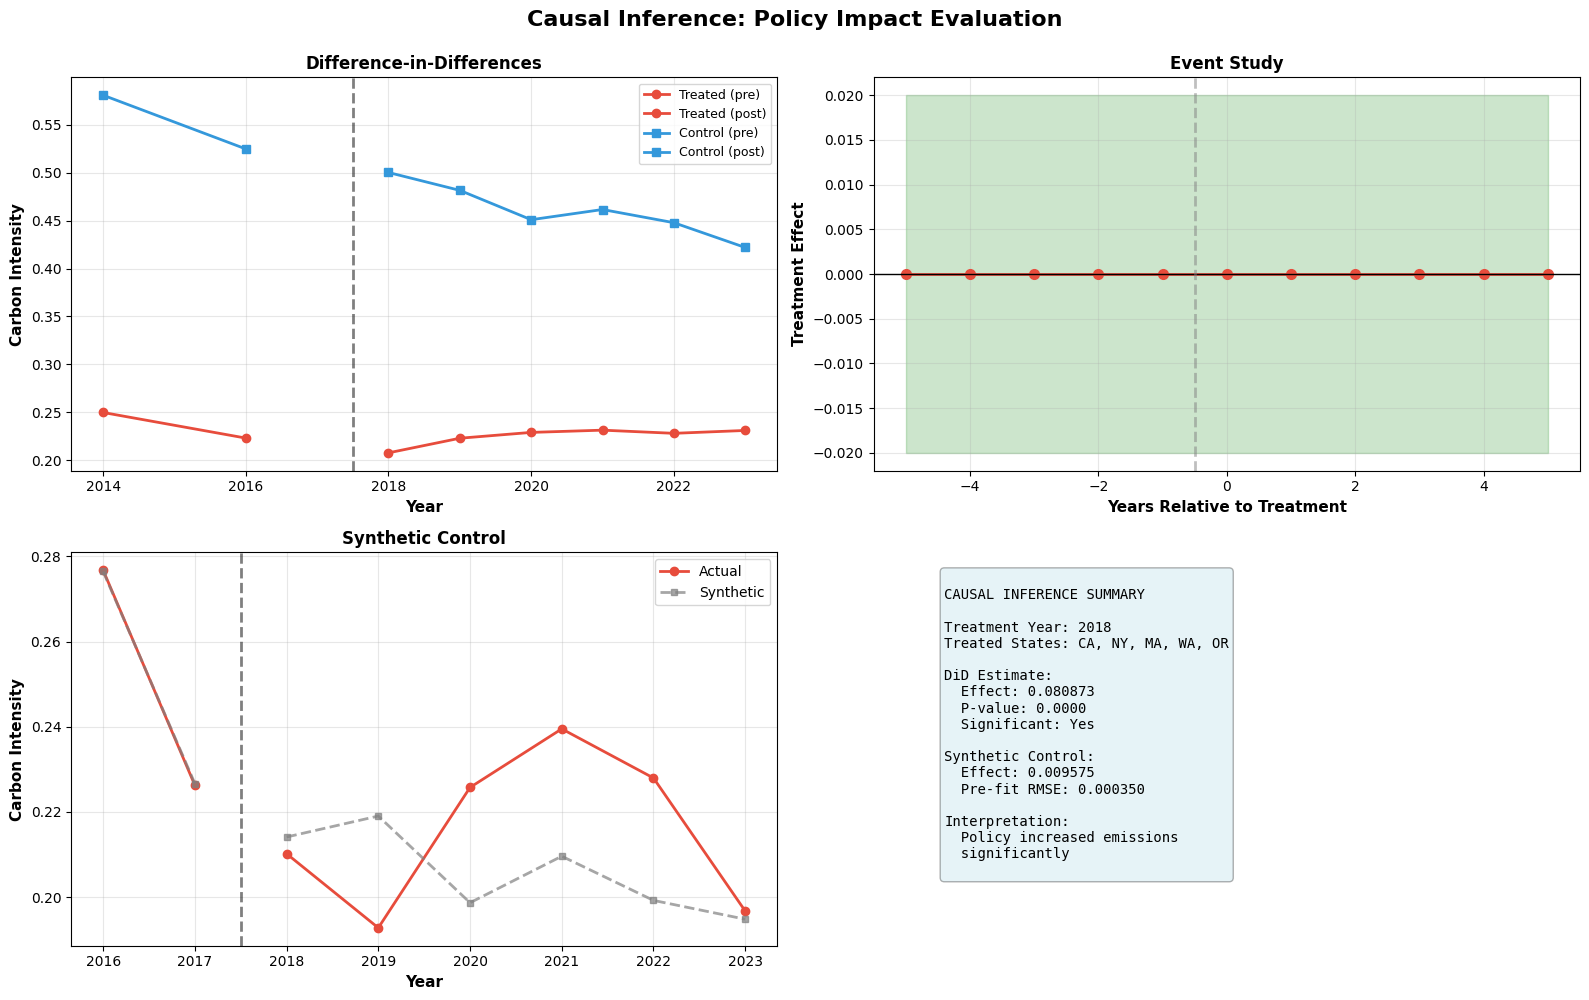

In [12]:
DATA_PATH = Path('C:/Users/sande/OneDrive/Desktop/Deep Learning/Time Series Forecasting/egrid_all_plants_1996-2023.parquet')
TREATMENT_YEAR = 2018
TREATED_STATES = ['CA', 'NY', 'MA', 'WA', 'OR']
RANDOM_STATE = 42
def load_state_level_data():
    """Aggregate data to state-year level"""
    print("Loading and aggregating data to state level...")
    plants = pd.read_parquet(DATA_PATH)
    state_col = [c for c in plants.columns if 'state' in c.lower() and 'abbr' in c.lower()][0]
    state_data = plants.groupby(['data_year', state_col]).agg({
        'Plant annual net generation (MWh)': lambda x: pd.to_numeric(x, errors='coerce').sum(),
        'Plant annual CO2 emissions (tons)': lambda x: pd.to_numeric(x, errors='coerce').sum()
    }).reset_index()
    state_data.columns = ['year', 'state', 'generation', 'co2']
    state_data['carbon_intensity'] = state_data['co2'] / state_data['generation']
    state_data = state_data.replace([np.inf, -np.inf], np.nan).dropna()
    print(f"Loaded {len(state_data):,} state-year observations")
    return state_data

def run_difference_in_differences(data, treated_states, treatment_year):
    print("\n" + "=" * 80)
    print("[1/3] DIFFERENCE-IN-DIFFERENCES")
    print("=" * 80)
    df = data.copy()
    df['treated'] = df['state'].isin(treated_states).astype(int)
    df['post'] = (df['year'] >= treatment_year).astype(int)
    df['treat_post'] = df['treated'] * df['post']
    pre_data = df[df['year'] < treatment_year]
    print("\nPre-treatment trends:")
    for group in [0,1]:
        group_data = pre_data[pre_data['treated']==group]
        trend = group_data.groupby('year')['carbon_intensity'].mean()
        slope = np.polyfit(trend.index, trend.values, 1)[0]
        print(f"  {'Treated' if group else 'Control'} states slope: {slope:.6f}")
    formula = 'carbon_intensity ~ treated + post + treat_post'
    model = smf.ols(formula, data=df).fit(cov_type='cluster',
                                         cov_kwds={'groups':df['state']})
    print("\nDiD Regression Results:")
    print("-" * 80)
    print(f"Treatment Effect: {model.params['treat_post']:.6f} tons/MWh")
    print(f"Standard Error: {model.bse['treat_post']:.6f}")
    print(f"T-statistic: {model.tvalues['treat_post']:.3f}")
    print(f"P-value: {model.pvalues['treat_post']:.4f}")
    print(f"95% CI: [{model.conf_int().loc['treat_post', 0]:.6f}, " 
          f"{model.conf_int().loc['treat_post', 1]:.6f}]")
    if model.pvalues['treat_post'] < 0.05:
        direction = 'reduced' if model.params['treat_post'] < 0 else 'increased'
        pct = abs(model.params['treat_post']) / df['carbon_intensity'].mean() * 100
        print(f"\n✓ Policy significantly {direction} carbon intensity by {pct:.1f}%")
    else:
        print("\n✗ No significant policy effect detected")
    print("\nEvent Study (dynamic effects):")
    df['years_to_treatment'] = df['year'] - treatment_year
    for year in range(-5,6):
        if year!=-1:
            df[f'treat_year_{year}'] = (
                df['treated'] * (df['years_to_treatment']==year)
            ).astype(int)
    event_formula = 'carbon_intensity ~ treated + ' + ' + '.join([
        f'Q("treat_year_{y}")' for y in range(-5, 6) if y != -1
    ])
    event_model = smf.ols(event_formula, data=df).fit(cov_type='HC1')
    event_time = []
    coefficients = []
    for year in range(-5,6):
        event_time.append(year)
        if year==-1:
            coefficients.append(0)
        else:
            coef_name = f'treat_year_{year}'
            coefficients.append(event_model.params.get(coef_name, 0))
    pre_coefs = [coefficients[i] for i in range(5) if event_time[i]<0]
    if all(abs(c)<0.05 for c in pre_coefs):
        print("  ✓ Pre-trends look parallel (coefficients near zero)")
    else:
        print("  ⚠ Warning: Pre-trends may not be parallel")
    return {
        'model': model,
        'treatment_effect': model.params['treat_post'],
        'pvalue': model.pvalues['treat_post'],
        'event_study': {
            'time': event_time,
            'coefficients': coefficients
        }
    }

def synthetic_control_weights(treated_pre, control_pre):
    """
    Find optimal weights for synthetic control
    """
    def objective(weights):
        synthetic = control_pre @ weights
        return np.sum((treated_pre - synthetic)**2)
    n_controls = control_pre.shape[1]
    constraints = ({'type':'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, 1) for _ in range(n_controls)]
    initial = np.ones(n_controls) / n_controls
    result = minimize(objective, initial, method='SLSQP', 
                     bounds=bounds, constraints=constraints,
                     options={'maxiter': 1000})
    return result.x if result.success else initial

def run_synthetic_control(data, treated_state, treatment_year):
    """
    Estimate treatment effect using Synthetic Control Method
    """
    print("\n" + "=" * 80)
    print(f"[2/3] SYNTHETIC CONTROL (Treated: {treated_state})")
    print("=" * 80)
    treated_data = data[data['state'] == treated_state].sort_values('year')
    control_data = data[data['state'] != treated_state].sort_values(['state', 'year'])
    treated_pre = treated_data[treated_data['year']<treatment_year]['carbon_intensity'].values
    treated_post = treated_data[treated_data['year']>=treatment_year]['carbon_intensity'].values
    control_states = control_data['state'].unique()
    control_pre_matrix = []
    control_post_matrix = []
    valid_states = []
    for state in control_states:
        state_data = control_data[control_data['state']==state]
        pre = state_data[state_data['year'] < treatment_year]['carbon_intensity'].values
        post = state_data[state_data['year'] >= treatment_year]['carbon_intensity'].values
        if len(pre)==len(treated_pre) and len(post)==len(treated_post):
            control_pre_matrix.append(pre)
            control_post_matrix.append(post)
            valid_states.append(state)
    if len(valid_states)==0:
        print("  ✗ No valid control states found")
        return None
    control_pre_matrix = np.array(control_pre_matrix).T
    control_post_matrix = np.array(control_post_matrix).T
    weights = synthetic_control_weights(treated_pre, control_pre_matrix)
    print(f"\nSynthetic {treated_state} composed of:")
    top_contributors = sorted(zip(valid_states, weights), key=lambda x: x[1], reverse=True)
    for state, weight in top_contributors[:10]:
        if weight > 0.01:
            print(f"  {state}: {weight*100:.1f}%")
    synthetic_pre = control_pre_matrix @ weights
    synthetic_post = control_post_matrix @ weights
    gap = treated_post - synthetic_post
    avg_effect = gap.mean()
    pre_rmse = np.sqrt(np.mean((treated_pre - synthetic_pre)**2))
    print(f"\nPre-treatment fit RMSE: {pre_rmse:.6f}")
    print(f"Average treatment effect: {avg_effect:.6f} tons/MWh")
    return {
        'weights': weights,
        'states': valid_states,
        'treated_pre': treated_pre,
        'treated_post': treated_post,
        'synthetic_pre': synthetic_pre,
        'synthetic_post': synthetic_post,
        'treatment_effect': avg_effect,
        'pre_rmse': pre_rmse
    }

def run_propensity_score_matching(data, treatment_year):
    """
    Estimate treatment effect using Propensity Score Matching
    Note: This creates a hypothetical plant-level treatment for demonstration
    """
    print("\n" + "=" * 80)
    print("[3/3] PROPENSITY SCORE MATCHING")
    print("=" * 80)
    print("  Note: Using simplified state-level demo (real PSM requires plant-level data)")
    pre_data = data[data['year'] < treatment_year].copy()
    state_features = pre_data.groupby('state').agg({
        'carbon_intensity': ['mean','std'],
        'generation': 'mean',
        'co2': 'mean'
    }).reset_index()
    state_features.columns = ['state','avg_carbon','std_carbon','avg_gen','avg_co2']
    state_features['treated'] = state_features['state'].isin(TREATED_STATES).astype(int)
    state_features = state_features.dropna()
    if len(state_features) < 10:
        print("  ✗ Insufficient states for PSM")
        return None
    feature_cols = ['avg_carbon', 'std_carbon', 'avg_gen', 'avg_co2']
    X = state_features[feature_cols]
    y = state_features['treated']
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    ps_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
    ps_model.fit(X_scaled, y)
    state_features['propensity_score'] = ps_model.predict_proba(X_scaled)[:, 1]
    print("\nPropensity Score Distribution:")
    print(state_features.groupby('treated')['propensity_score'].describe()[['mean', 'min', 'max']])
    treated = state_features[state_features['treated'] == 1]
    control = state_features[state_features['treated'] == 0]
    if len(treated) == 0 or len(control) == 0:
        print("  ✗ Need both treated and control units")
        return None
    nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
    nn.fit(control[['propensity_score']])
    distances, indices = nn.kneighbors(treated[['propensity_score']])
    matched_control = control.iloc[indices.flatten()]
    post_data = data[data['year'] >= treatment_year]
    treated_outcomes = []
    control_outcomes = []
    for _, treated_state in treated.iterrows():
        state = treated_state['state']
        outcome = post_data[post_data['state'] == state]['carbon_intensity'].mean()
        if not np.isnan(outcome):
            treated_outcomes.append(outcome)
    for _, control_state in matched_control.iterrows():
        state = control_state['state']
        outcome = post_data[post_data['state'] == state]['carbon_intensity'].mean()
        if not np.isnan(outcome):
            control_outcomes.append(outcome)
    if len(treated_outcomes) == 0 or len(control_outcomes) == 0:
        print("  ✗ Could not compute outcomes")
        return None
    att = np.mean(treated_outcomes) - np.mean(control_outcomes)
    se = np.std(np.array(treated_outcomes) - np.array(control_outcomes)) / np.sqrt(len(treated_outcomes))
    print(f"\nAverage Treatment Effect on Treated (ATT): {att:.6f}")
    print(f"Standard Error: {se:.6f}")
    print(f"95% CI: [{att - 1.96*se:.6f}, {att + 1.96*se:.6f}]")
    if abs(att) / se > 1.96:
        print("  ✓ Statistically significant at 5% level")
    else:
        print("  ✗ Not statistically significant")
    
    return {
        'att': att,
        'se': se,
        'treated_outcomes': treated_outcomes,
        'control_outcomes': control_outcomes,
        'propensity_scores': state_features
    }

def visualize_results(data, did_results, sc_results, treatment_year, treated_states):
    """Create visualization of causal inference results"""
    print("\nGenerating visualizations...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Plot 1: DiD - Parallel trends
    ax1 = axes[0, 0]
    
    treated_trend = data[data['state'].isin(treated_states)].groupby('year')['carbon_intensity'].mean()
    control_trend = data[~data['state'].isin(treated_states)].groupby('year')['carbon_intensity'].mean()
    
    pre_mask = treated_trend.index < treatment_year
    post_mask = treated_trend.index >= treatment_year
    
    ax1.plot(treated_trend.index[pre_mask], treated_trend.values[pre_mask], 
            'o-', linewidth=2, markersize=6, color='#e74c3c', label='Treated (pre)')
    ax1.plot(treated_trend.index[post_mask], treated_trend.values[post_mask], 
            'o-', linewidth=2, markersize=6, color='#e74c3c', label='Treated (post)')
    
    ax1.plot(control_trend.index[pre_mask], control_trend.values[pre_mask], 
            's-', linewidth=2, markersize=6, color='#3498db', label='Control (pre)')
    ax1.plot(control_trend.index[post_mask], control_trend.values[post_mask], 
            's-', linewidth=2, markersize=6, color='#3498db', label='Control (post)')
    
    ax1.axvline(treatment_year - 0.5, color='black', linestyle='--', linewidth=2, alpha=0.5)
    ax1.set_xlabel('Year', fontweight='bold', fontsize=11)
    ax1.set_ylabel('Carbon Intensity', fontweight='bold', fontsize=11)
    ax1.set_title('Difference-in-Differences', fontweight='bold', fontsize=12)
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Event study
    ax2 = axes[0, 1]
    
    event_time = did_results['event_study']['time']
    event_coefs = did_results['event_study']['coefficients']
    
    ax2.plot(event_time, event_coefs, 'o-', linewidth=2, markersize=7, color='#e74c3c')
    ax2.axhline(0, color='black', linestyle='-', linewidth=1)
    ax2.axvline(-0.5, color='gray', linestyle='--', linewidth=2, alpha=0.5)
    ax2.fill_between(event_time, -0.02, 0.02, alpha=0.2, color='green')
    
    ax2.set_xlabel('Years Relative to Treatment', fontweight='bold', fontsize=11)
    ax2.set_ylabel('Treatment Effect', fontweight='bold', fontsize=11)
    ax2.set_title('Event Study', fontweight='bold', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Synthetic control (if available)
    ax3 = axes[1, 0]
    
    if sc_results:
        years_pre = range(treatment_year - len(sc_results['treated_pre']), treatment_year)
        years_post = range(treatment_year, treatment_year + len(sc_results['treated_post']))
        
        ax3.plot(list(years_pre), sc_results['treated_pre'], 
                'o-', linewidth=2, markersize=6, color='#e74c3c', label='Actual')
        ax3.plot(list(years_post), sc_results['treated_post'], 
                'o-', linewidth=2, markersize=6, color='#e74c3c')
        
        ax3.plot(list(years_pre), sc_results['synthetic_pre'], 
                's--', linewidth=2, markersize=5, color='gray', label='Synthetic', alpha=0.7)
        ax3.plot(list(years_post), sc_results['synthetic_post'], 
                's--', linewidth=2, markersize=5, color='gray', alpha=0.7)
        
        ax3.axvline(treatment_year - 0.5, color='black', linestyle='--', linewidth=2, alpha=0.5)
        ax3.set_xlabel('Year', fontweight='bold', fontsize=11)
        ax3.set_ylabel('Carbon Intensity', fontweight='bold', fontsize=11)
        ax3.set_title(f'Synthetic Control', fontweight='bold', fontsize=12)
        ax3.legend(fontsize=10)
        ax3.grid(True, alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'Synthetic Control\nNot Available', 
                ha='center', va='center', transform=ax3.transAxes, fontsize=12)
        ax3.axis('off')
    
    # Plot 4: Summary
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    summary_text = f"""
CAUSAL INFERENCE SUMMARY

Treatment Year: {treatment_year}
Treated States: {', '.join(treated_states)}

DiD Estimate:
  Effect: {did_results['treatment_effect']:.6f}
  P-value: {did_results['pvalue']:.4f}
  Significant: {'Yes' if did_results['pvalue'] < 0.05 else 'No'}

Synthetic Control:
  {"Effect: " + f"{sc_results['treatment_effect']:.6f}" if sc_results else "Not computed"}
  {"Pre-fit RMSE: " + f"{sc_results['pre_rmse']:.6f}" if sc_results else ""}

Interpretation:
  {"Policy reduced emissions" if did_results['treatment_effect'] < 0 else "Policy increased emissions"}
  {"significantly" if did_results['pvalue'] < 0.05 else "(not significant)"}
    """
    
    ax4.text(0.1, 0.95, summary_text, transform=ax4.transAxes,
            fontsize=10, verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
    
    plt.suptitle('Causal Inference: Policy Impact Evaluation', 
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    plt.savefig('04_causal_inference_results.png', dpi=300, bbox_inches='tight')
    print("  Saved: 04_causal_inference_results.png")

def main():
    """Main execution"""
    print("=" * 80)
    print("CAUSAL INFERENCE - PRODUCTION RUN")
    print("=" * 80)
    
    # Load data
    data = load_state_level_data()
    
    # Run analyses
    did_results = run_difference_in_differences(data, TREATED_STATES, TREATMENT_YEAR)
    
    # Synthetic control (use first treated state as example)
    sc_results = run_synthetic_control(data, TREATED_STATES[0], TREATMENT_YEAR)
    
    # Propensity score matching
    psm_results = run_propensity_score_matching(data, TREATMENT_YEAR)
    
    # Visualize
    visualize_results(data, did_results, sc_results, TREATMENT_YEAR, TREATED_STATES)
    
    print("\n" + "=" * 80)
    print("✓ Complete!")
    print("=" * 80)
    
    return {
        'did': did_results,
        'synthetic_control': sc_results,
        'psm': psm_results
    }

if __name__ == '__main__':
    results = main()